In [19]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from SuperpixelCutsPy import *
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(suppress=True)

In [20]:
dataset_name = 'fields_data_2022'
h5_import = h5py.File("data/bhsi_2022.h5",'r+').get('Cube/resultarray/inputdata')
hyperspectral_cube = np.array(h5_import)
hyperspectral_cube = np.moveaxis(np.array(hyperspectral_cube), [0], [2])
hyperspectral_cube = np.moveaxis(np.array(hyperspectral_cube), [0], [1])
original_hyperspectral_cube = hyperspectral_cube.copy()
hyperspectral_cube = hyperspectral_cube[5:205, 5:205, :].copy()
nx,ny,nb = hyperspectral_cube.shape
del h5_import

In [21]:
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
#original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()

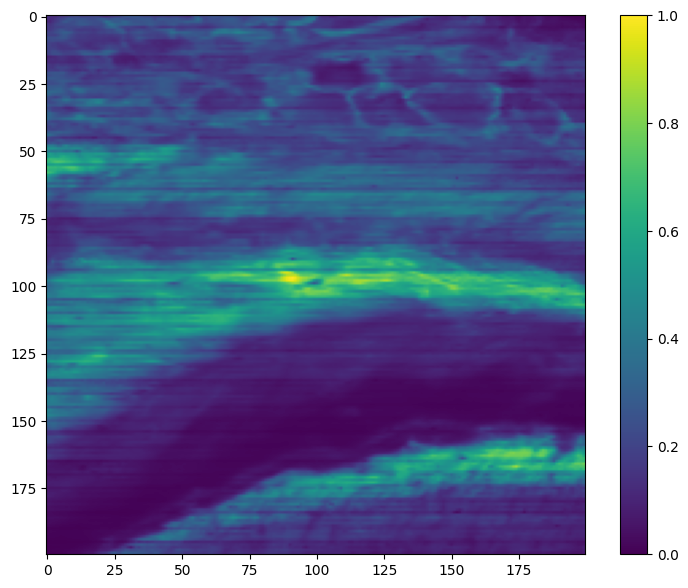

In [22]:
plt.imshow(hyperspectral_cube[:,:,0]);
plt.colorbar();

In [23]:
n_superpixels = 2500 #2500
slic_m_param = 2    #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))

Created 2500 superpixels


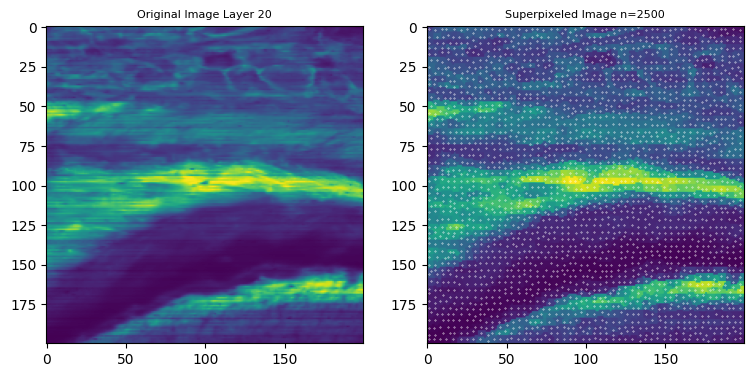

In [24]:
fig, ax = plt.subplots(1,2, dpi=100);
layer_preview = 20
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[1].imshow(superpixeled_cube[:,:,layer_preview])
ax[1].scatter(centers[:,1], centers[:,0], c='white', s=0.1);
ax[0].set_title(f'Original Image Layer {layer_preview}', fontsize = 8);
ax[1].set_title(f'Superpixeled Image n={len(np.unique(assignments))}', fontsize = 8);

In [25]:
sigma_param = 0.01 # 0.1 -> 0.001           #0.01
spatial_limit = 35# 15 -> 25 in steps of 5 #15
ne = 6#number of endmembers

superpixel_cluster_labels, mean_cluster_spectra = normalized_cuts.single_ncuts_admm(data=hyperspectral_cube,
                                                                                superpixel_library=superpixel_library,
                                                                                superpixel_centers=centers,
                                                                                superpixel_assignments=assignments,
                                                                                n_endmembers=ne,
                                                                                spectral_sigma2_param=sigma_param,
                                                                                spatial_kappa_param=spatial_limit,
                                                                                spectral_metric='EUCLIDEAN')

labelled_img = normalized_cuts.assign_labels_onto_image(assignments, superpixel_cluster_labels)

_, superpixel_original_library = superpixel.generate_SLIC_superpixels(data = original_hyperspectral_cube,
                                                                      assignments = assignments)

original_library = segmentation_evaluation.calc_mean_label_signatures(superpixel_original_library, superpixel_cluster_labels)

c:\Users\apopo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clustering
Spectral + Unmixing Clustering


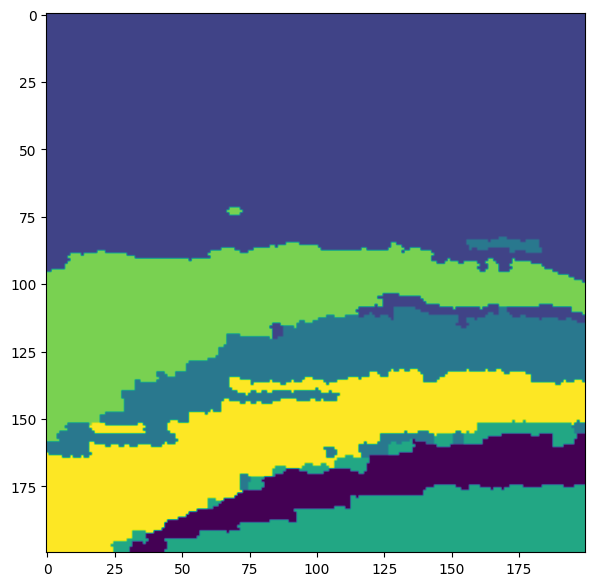

In [26]:
plt.imshow(labelled_img);

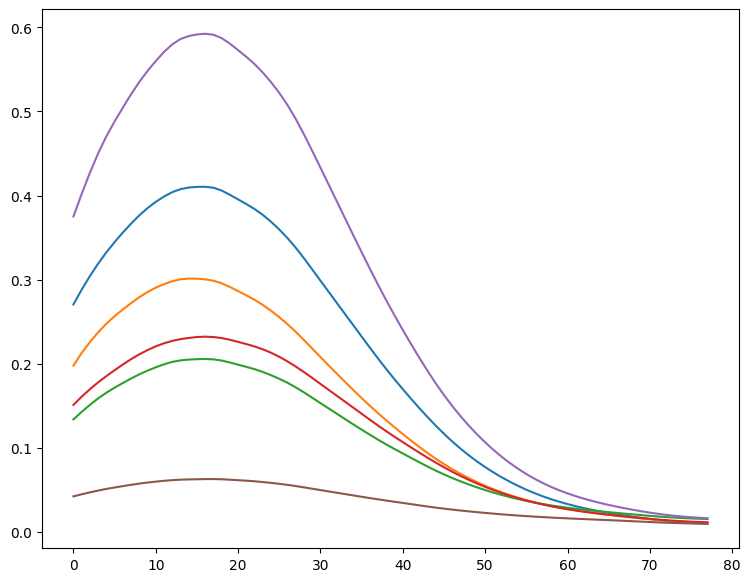

In [27]:
plt.plot((original_library - original_hyperspectral_cube.min())/(original_hyperspectral_cube.max() - original_hyperspectral_cube.min()));

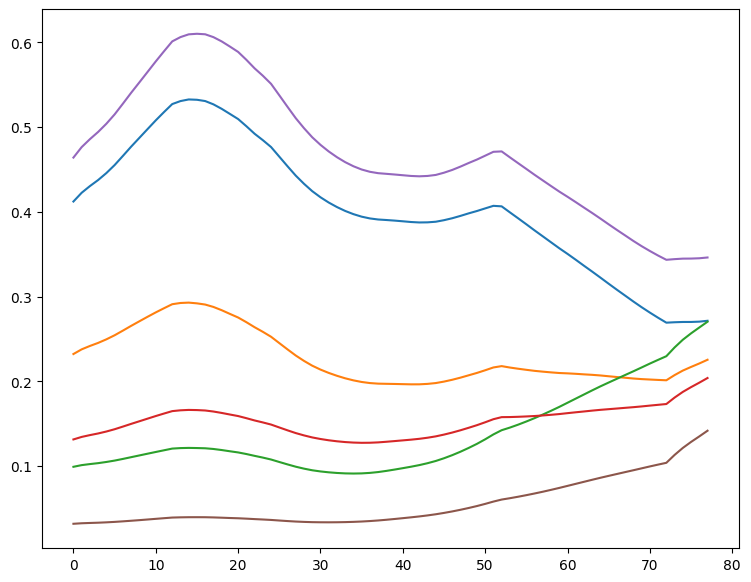

In [28]:
plt.plot(mean_cluster_spectra);